Préparation des données

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.multiclass import unique_labels
import joblib
# Importations spécifiques aux modèles
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Importations pour le traçage (plotting)
import matplotlib.pyplot as plt # Pour les graphiques
import seaborn as sns    

# --- 1. Fonction d'évaluation des métriques ---
def evaluate_model(model, X_test, y_test, model_name, label_encoder):
    """
    Évalue un modèle et imprime ses métriques de performance.
    """
    y_pred = model.predict(X_test)

    print(f"\n=== Évaluation du modèle : {model_name} ===")
    print(f" Accuracy : {accuracy_score(y_test, y_pred):.2f}")

    labels_present_in_report = unique_labels(y_test, y_pred)
    class_names_for_report = [str(x) for x in label_encoder.classes_[labels_present_in_report]]

    print("\n Rapport de classification :")
    print(classification_report(y_test, y_pred, target_names=class_names_for_report, zero_division=0))

    return y_pred # Retourne les prédictions pour la matrice de confusion

# --- 2. Fonction de tracé de la matrice de confusion inversée ---
def plot_inverted_confusion_matrix(y_true, y_pred, label_encoder, model_name, cmap):
    """
    Trace une matrice de confusion avec l'axe Y (vraies classes) inversé.
    """
    # Détecter les labels numériques uniques présents dans y_true et y_pred
    labels_present_numeric = unique_labels(y_true, y_pred)

    # Convertir les labels numériques présents en leurs noms de classes correspondants
    class_names = [str(x) for x in label_encoder.classes_[labels_present_numeric]]

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_true, y_pred, labels=labels_present_numeric)

    # Inverser les lignes de la matrice de confusion
    cm_inverted = cm[::-1]

    # Inverser les étiquettes de l'axe Y pour qu'elles correspondent à l'inversion des lignes
    yticklabels_inverted = class_names[::-1]

    # Créer l'étiquette dynamique pour l'axe Y
    y_label_text = f"Vraie classe (bas = {yticklabels_inverted[0]}, haut = {yticklabels_inverted[-1]})"

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_inverted, annot=True, fmt="d", cmap=cmap,
                xticklabels=class_names, # L'axe X (prédictions) utilise l'ordre standard
                yticklabels=yticklabels_inverted) # L'axe Y (vraies classes) utilise l'ordre inversé
    plt.xlabel("Classe prédite")
    plt.ylabel(y_label_text)
    plt.title(f"Matrice de confusion - {model_name} (axe Y inversé)", fontsize=14)
    plt.tight_layout() # Ajuste la mise en page pour éviter les chevauchements
    plt.show()


    
# 1. Chargement des données
df = pd.read_csv("export_IA.csv")

# 2. Garder une seule ligne par navire (la plus ancienne si BaseDateTime existe)
if "BaseDateTime" in df.columns:
    df = df.sort_values("BaseDateTime")

df_unique = df.drop_duplicates(subset="MMSI", keep="first").reset_index(drop=True)
print(f" Navires uniques conservés : {len(df_unique)}")

# 3. Supprimer les classes trop rares (1 seul échantillon = pas de stratification possible)
vc = df_unique["VesselType"].value_counts()
valid_classes = vc[vc >= 2].index
df_unique = df_unique[df_unique["VesselType"].isin(valid_classes)].reset_index(drop=True)
print(f" Classes conservées : {list(valid_classes)}")

# 4. Sélection des variables
features = ['Length', 'Width', 'Draft']
target = 'VesselType'
X = df_unique[features].copy()
y = df_unique[target].copy()

# 5. Encodage de la cible
le = LabelEncoder()
y_enc = le.fit_transform(y)

# 6. Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7. Split train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# 8. Sauvegarde des objets
joblib.dump(scaler, "scaler.save")
joblib.dump(le, "label_encoder.save")

# 9. Affichage de contrôle
print(f" Entraînement : {X_train.shape[0]} lignes")
print(f" Test        : {X_test.shape[0]} lignes")
print(" Classes encodées :", list(le.classes_))


 Navires uniques conservés : 144
 Classes conservées : [80, 70, 60, 71, 89, 79, 69]
 Entraînement : 112 lignes
 Test        : 28 lignes
 Classes encodées : [np.int64(60), np.int64(69), np.int64(70), np.int64(71), np.int64(79), np.int64(80), np.int64(89)]


Random Forest


--- Démarrage : Entraînement et Évaluation de Random Forest ---
Modèle Random Forest entraîné.

=== Évaluation du modèle : Random Forest ===
 Accuracy : 0.75

 Rapport de classification :
              precision    recall  f1-score   support

          60       1.00      1.00      1.00         8
          70       0.83      0.62      0.71         8
          71       0.00      0.00      0.00         1
          79       0.00      0.00      0.00         1
          80       0.62      0.89      0.73         9
          89       0.00      0.00      0.00         1

    accuracy                           0.75        28
   macro avg       0.41      0.42      0.41        28
weighted avg       0.72      0.75      0.72        28



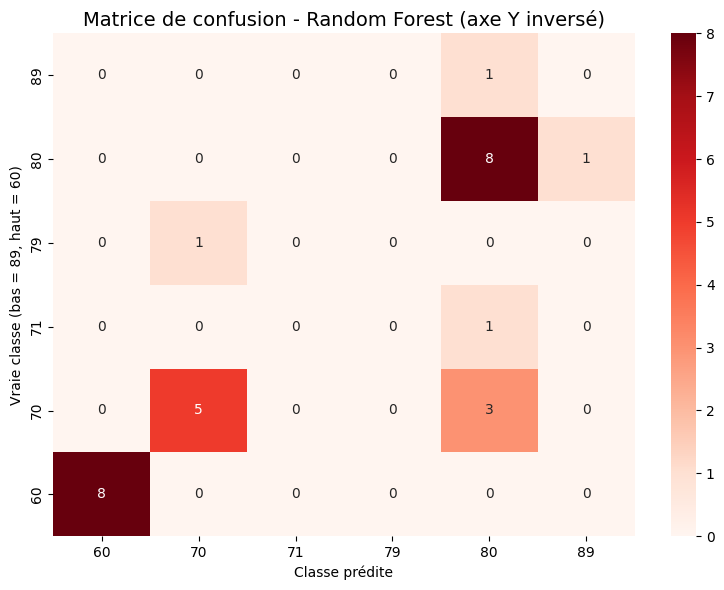

In [90]:
print("\n--- Démarrage : Entraînement et Évaluation de Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42) # Paramètres par défaut ou choisis
rf_model.fit(X_train, y_train)
print("Modèle Random Forest entraîné.")

y_pred_rf = evaluate_model(rf_model, X_test, y_test, "Random Forest", le)
plot_inverted_confusion_matrix(y_test, y_pred_rf, le, "Random Forest",'Reds')

Régression Logistique


--- Démarrage : Entraînement et Évaluation de la Régression Logistique ---
Modèle Régression Logistique entraîné.

=== Évaluation du modèle : Régression Logistique ===
 Accuracy : 0.71

 Rapport de classification :
              precision    recall  f1-score   support

          60       0.89      1.00      0.94         8
          70       0.80      0.50      0.62         8
          71       0.00      0.00      0.00         1
          79       0.00      0.00      0.00         1
          80       0.57      0.89      0.70         9
          89       0.00      0.00      0.00         1

    accuracy                           0.71        28
   macro avg       0.38      0.40      0.38        28
weighted avg       0.67      0.71      0.67        28



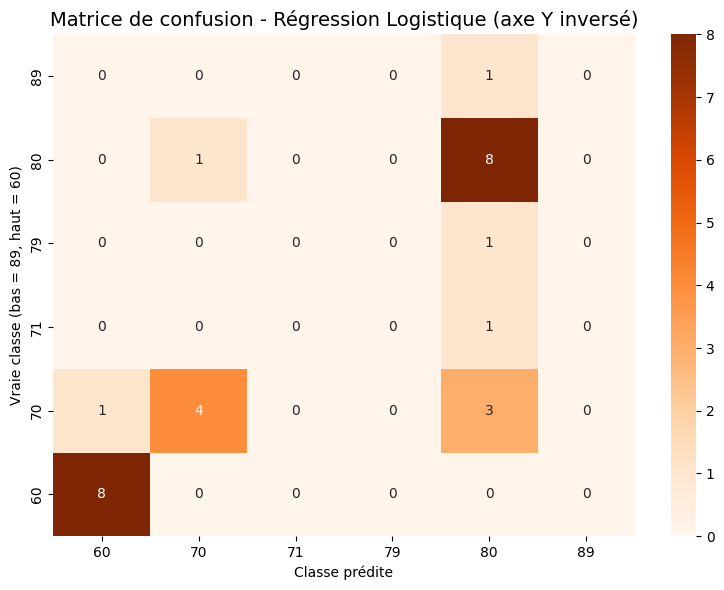

In [91]:
print("\n--- Démarrage : Entraînement et Évaluation de la Régression Logistique ---")
lr_model = LogisticRegression(max_iter=200, random_state=42) # Paramètres par défaut ou choisis
lr_model.fit(X_train, y_train)
print("Modèle Régression Logistique entraîné.")

y_pred_lr = evaluate_model(lr_model, X_test, y_test, "Régression Logistique", le)
plot_inverted_confusion_matrix(y_test, y_pred_lr, le, "Régression Logistique",'Oranges')


Decision Tree


--- Démarrage : Entraînement et Évaluation de l'Arbre de Décision ---
Modèle Arbre de Décision entraîné.

=== Évaluation du modèle : Arbre de Décision ===
 Accuracy : 0.64

 Rapport de classification :
              precision    recall  f1-score   support

          60       1.00      0.88      0.93         8
          70       0.57      0.50      0.53         8
          71       0.00      0.00      0.00         1
          79       0.00      0.00      0.00         1
          80       0.58      0.78      0.67         9
          89       0.00      0.00      0.00         1

    accuracy                           0.64        28
   macro avg       0.36      0.36      0.36        28
weighted avg       0.64      0.64      0.63        28



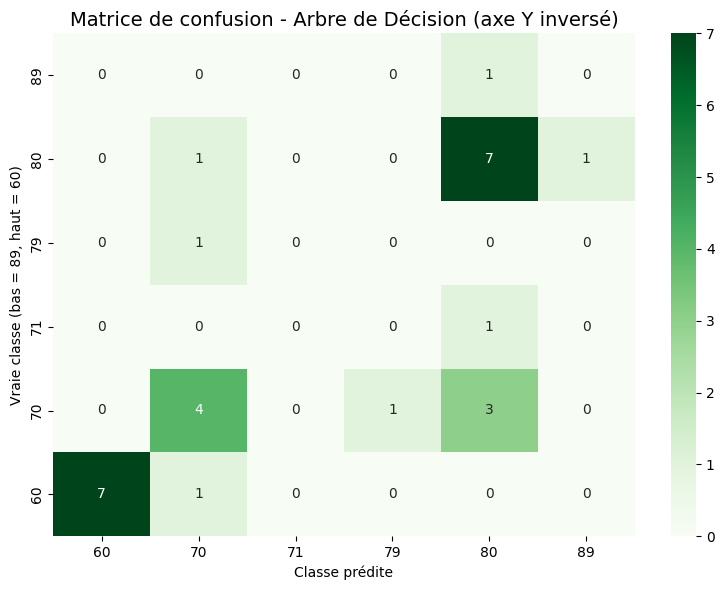

In [92]:
print("\n--- Démarrage : Entraînement et Évaluation de l'Arbre de Décision ---")
dt_model = DecisionTreeClassifier(max_depth=None, random_state=42) # Paramètres par défaut ou choisis
dt_model.fit(X_train, y_train)
print("Modèle Arbre de Décision entraîné.")

y_pred_dt = evaluate_model(dt_model, X_test, y_test, "Arbre de Décision", le)
plot_inverted_confusion_matrix(y_test, y_pred_dt, le, "Arbre de Décision",'Greens')

SVM


--- Démarrage : Entraînement et Évaluation de SVM ---
Modèle SVM entraîné.

=== Évaluation du modèle : SVM ===
 Accuracy : 0.64

 Rapport de classification :
              precision    recall  f1-score   support

          60       0.89      1.00      0.94         8
          70       0.67      0.25      0.36         8
          71       0.00      0.00      0.00         1
          79       0.00      0.00      0.00         1
          80       0.50      0.89      0.64         9
          89       0.00      0.00      0.00         1

    accuracy                           0.64        28
   macro avg       0.34      0.36      0.32        28
weighted avg       0.61      0.64      0.58        28



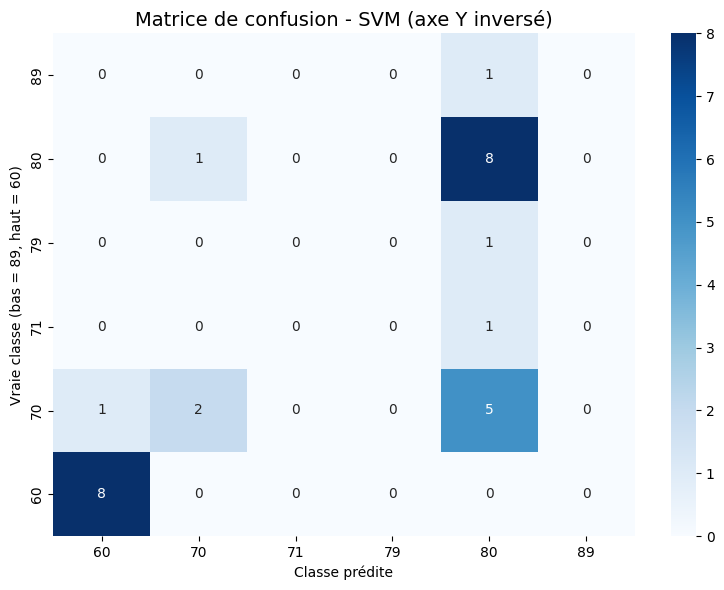

In [93]:
print("\n--- Démarrage : Entraînement et Évaluation de SVM ---")
svm_model = SVC(random_state=42) # Paramètres par défaut ou choisis
svm_model.fit(X_train, y_train)
print("Modèle SVM entraîné.")

y_pred_svm = evaluate_model(svm_model, X_test, y_test, "SVM", le)
plot_inverted_confusion_matrix(y_test, y_pred_svm, le, "SVM",'Blues')

KNN


--- Démarrage : Entraînement et Évaluation de KNN ---
Modèle KNN entraîné.

=== Évaluation du modèle : KNN ===
 Accuracy : 0.68

 Rapport de classification :
              precision    recall  f1-score   support

          60       1.00      1.00      1.00         8
          70       0.45      0.62      0.53         8
          71       0.00      0.00      0.00         1
          79       0.00      0.00      0.00         1
          80       0.67      0.67      0.67         9
          89       0.00      0.00      0.00         1

    accuracy                           0.68        28
   macro avg       0.35      0.38      0.37        28
weighted avg       0.63      0.68      0.65        28



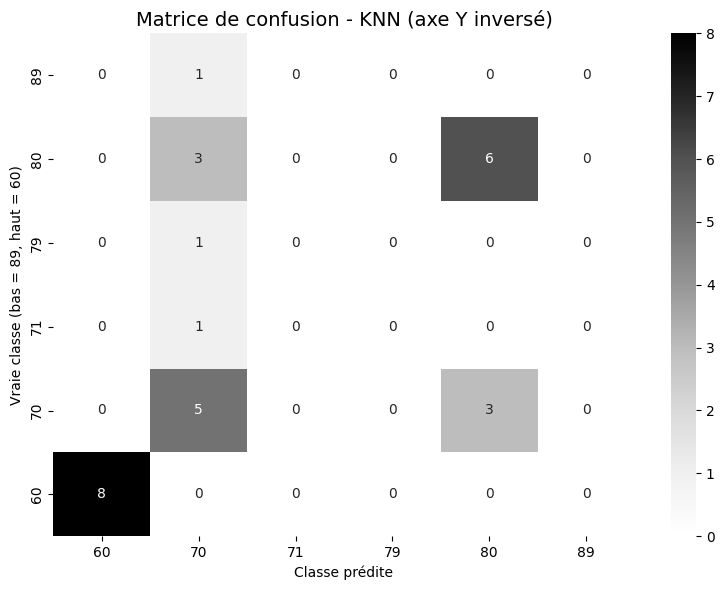

In [94]:
print("\n--- Démarrage : Entraînement et Évaluation de KNN ---")
knn_model = KNeighborsClassifier(n_neighbors=5) # Paramètres par défaut ou choisis
knn_model.fit(X_train, y_train)
print("Modèle KNN entraîné.")

y_pred_knn = evaluate_model(knn_model, X_test, y_test, "KNN", le)
plot_inverted_confusion_matrix(y_test, y_pred_knn, le, "KNN",'Greys')


In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Dictionnaire des modèles dans l'ordre souhaité
models = {
    "Random Forest": rf_model,
    "Régression Logistique": lr_model,
    "Decision Tree": dt_model,
    "SVM": svm_model,
    "KNN": knn_model
}

# Liste pour stocker les résultats
results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    results.append({
        "Modèle": name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 4),
        "Precision": round(precision_score(y_test, y_pred, average='macro', zero_division=0), 4),
        "Recall": round(recall_score(y_test, y_pred, average='macro', zero_division=0), 4),
        "F1-score": round(f1_score(y_test, y_pred, average='macro', zero_division=0), 4)
    })

# Création du DataFrame
df_results = pd.DataFrame(results)
print(df_results)


                  Modèle  Accuracy  Precision  Recall  F1-score
0          Random Forest    0.7500     0.4081  0.4190    0.4069
1  Régression Logistique    0.7143     0.3767  0.3981    0.3754
2          Decision Tree    0.6429     0.3591  0.3588    0.3556
3                    SVM    0.6429     0.3426  0.3565    0.3241
4                    KNN    0.6786     0.3535  0.3819    0.3655


GridsearchCV

Random Forest


--- Exécution de GridSearchCV pour Random Forest ---


/home/isen/projet/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Meilleurs paramètres RF : {'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 50}
Meilleur score de validation croisée RF : 0.75

=== Évaluation du modèle : Random Forest Optimisé ===
 Accuracy : 0.82

 Rapport de classification :
              precision    recall  f1-score   support

          60       1.00      1.00      1.00         8
          70       0.86      0.75      0.80         8
          71       0.00      0.00      0.00         1
          79       0.00      0.00      0.00         1
          80       0.69      1.00      0.82         9
          89       0.00      0.00      0.00         1

    accuracy                           0.82        28
   macro avg       0.42      0.46      0.44        28
weighted avg       0.75      0.82      0.78        28



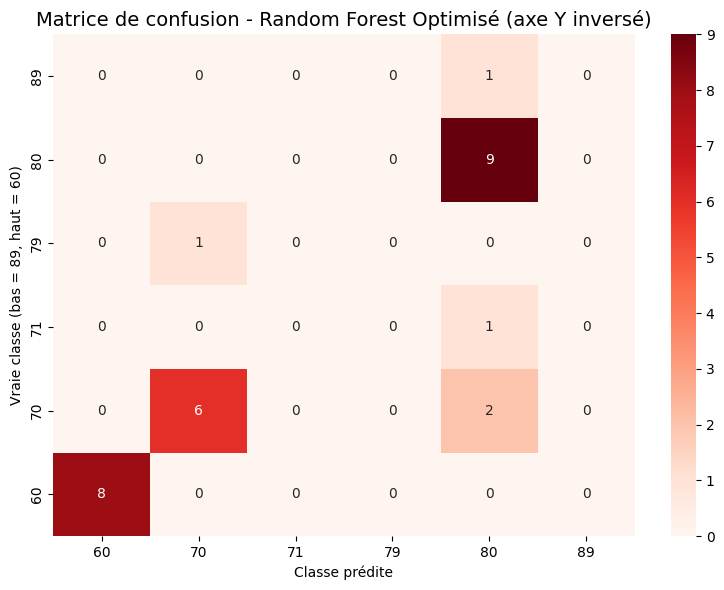

Modèle Random Forest optimisé enregistré sous random_forest_model_tuned.pkl


In [96]:
from sklearn.model_selection import GridSearchCV
print("\n--- Exécution de GridSearchCV pour Random Forest ---")
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 5]
}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres RF : {rf_grid_search.best_params_}")
print(f"Meilleur score de validation croisée RF : {rf_grid_search.best_score_:.2f}")

# Utilisation de la fonction d'évaluation définie précédemment
y_pred_rf_optimized = evaluate_model(rf_grid_search.best_estimator_, X_test, y_test, "Random Forest Optimisé",le)
plot_inverted_confusion_matrix(y_test, y_pred_rf_optimized,le, "Random Forest Optimisé", 'Reds')
# Sauvegarde du modèle optimisé
joblib.dump(rf_grid_search.best_estimator_, "random_forest_model_tuned.pkl")
print("Modèle Random Forest optimisé enregistré sous random_forest_model_tuned.pkl")

Régression Logistique


--- Exécution de GridSearchCV pour Régression Logistique ---
Meilleurs paramètres LR : {'C': 10.0, 'max_iter': 200, 'solver': 'lbfgs'}
Meilleur score de validation croisée LR : 0.63

=== Évaluation du modèle : Régression Logistique Optimisée ===
 Accuracy : 0.71

 Rapport de classification :
              precision    recall  f1-score   support

          60       0.89      1.00      0.94         8
          70       0.80      0.50      0.62         8
          71       0.00      0.00      0.00         1
          79       0.00      0.00      0.00         1
          80       0.57      0.89      0.70         9
          89       0.00      0.00      0.00         1

    accuracy                           0.71        28
   macro avg       0.38      0.40      0.38        28
weighted avg       0.67      0.71      0.67        28



/home/isen/projet/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/home/isen/projet/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/isen/projet/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/isen/projet/venv/lib/python

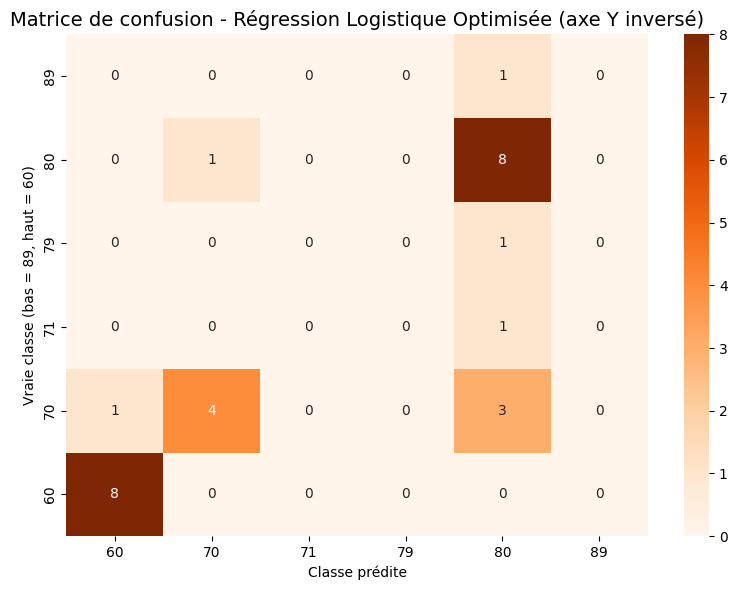

Modèle Régression Logistique optimisé enregistré sous logistic_regression_model_tuned.pkl


In [97]:
print("\n--- Exécution de GridSearchCV pour Régression Logistique ---")
lr_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [200]
}
lr_grid_search = GridSearchCV(LogisticRegression(random_state=42), lr_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
lr_grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres LR : {lr_grid_search.best_params_}")
print(f"Meilleur score de validation croisée LR : {lr_grid_search.best_score_:.2f}")

# Utilisation de la fonction d'évaluation définie précédemment
y_pred_lr_optimized = evaluate_model(lr_grid_search.best_estimator_, X_test, y_test, "Régression Logistique Optimisée",le)
plot_inverted_confusion_matrix(y_test, y_pred_lr_optimized,le, "Régression Logistique Optimisée", 'Oranges')
# Sauvegarde du modèle optimisé
joblib.dump(lr_grid_search.best_estimator_, "logistic_regression_model_tuned.pkl")
print("Modèle Régression Logistique optimisé enregistré sous logistic_regression_model_tuned.pkl")

Decision Tree


--- Exécution de GridSearchCV pour Arbre de Décision ---
Meilleurs paramètres DT : {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5}
Meilleur score de validation croisée DT : 0.72

=== Évaluation du modèle : Arbre de Décision Optimisé ===
 Accuracy : 0.82

 Rapport de classification :
              precision    recall  f1-score   support

          60       1.00      1.00      1.00         8
          70       0.86      0.75      0.80         8
          71       0.00      0.00      0.00         1
          79       0.00      0.00      0.00         1
          80       0.69      1.00      0.82         9
          89       0.00      0.00      0.00         1

    accuracy                           0.82        28
   macro avg       0.42      0.46      0.44        28
weighted avg       0.75      0.82      0.78        28



/home/isen/projet/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


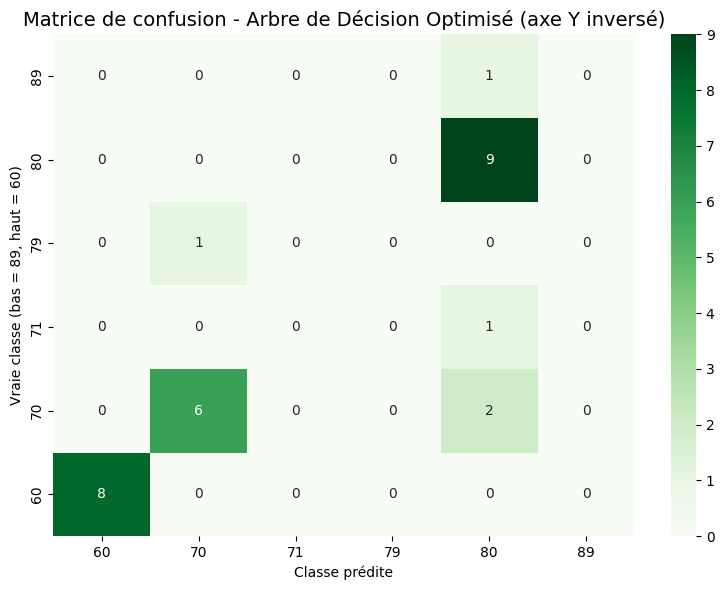

Modèle Arbre de Décision optimisé enregistré sous decision_tree_model_tuned.pkl


In [98]:
print("\n--- Exécution de GridSearchCV pour Arbre de Décision ---")
dt_param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres DT : {dt_grid_search.best_params_}")
print(f"Meilleur score de validation croisée DT : {dt_grid_search.best_score_:.2f}")

# Utilisation de la fonction d'évaluation définie précédemment
# Evaluate and plot for the optimized Decision Tree model
y_pred_dt_optimized = evaluate_model(dt_grid_search.best_estimator_, X_test, y_test, "Arbre de Décision Optimisé",le)
plot_inverted_confusion_matrix(y_test, y_pred_dt_optimized,le, "Arbre de Décision Optimisé", 'Greens')
# Sauvegarde du modèle optimisé
joblib.dump(dt_grid_search.best_estimator_, "decision_tree_model_tuned.pkl")
print("Modèle Arbre de Décision optimisé enregistré sous decision_tree_model_tuned.pkl")

SVM


--- Exécution de GridSearchCV pour SVM ---
Meilleurs paramètres SVM : {'C': 10.0, 'gamma': 'scale', 'kernel': 'linear'}
Meilleur score de validation croisée SVM : 0.64

=== Évaluation du modèle : SVC Optimisé ===
 Accuracy : 0.68

 Rapport de classification :
              precision    recall  f1-score   support

          60       0.89      1.00      0.94         8
          70       0.57      0.50      0.53         8
          71       0.00      0.00      0.00         1
          79       0.00      0.00      0.00         1
          80       0.58      0.78      0.67         9
          89       0.00      0.00      0.00         1

    accuracy                           0.68        28
   macro avg       0.34      0.38      0.36        28
weighted avg       0.60      0.68      0.64        28



/home/isen/projet/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


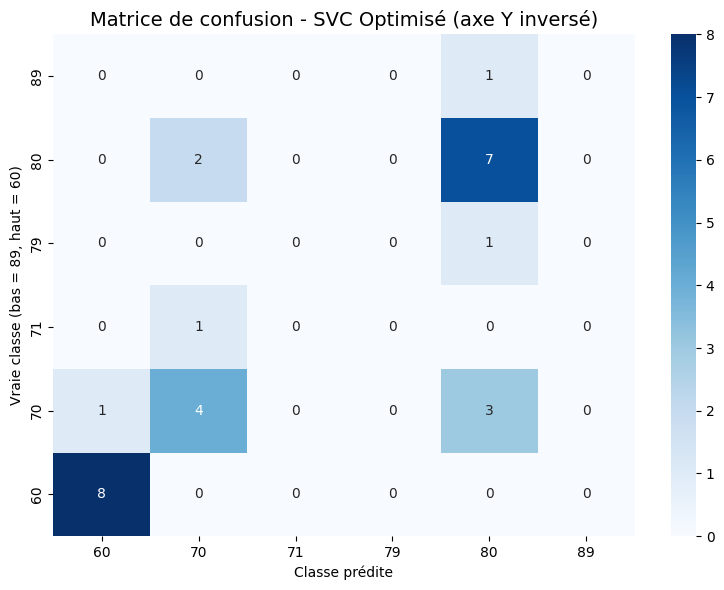

Modèle SVM optimisé enregistré sous svm_model_tuned.pkl


In [99]:
print("\n--- Exécution de GridSearchCV pour SVM ---")
svm_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_grid_search = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
svm_grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres SVM : {svm_grid_search.best_params_}")
print(f"Meilleur score de validation croisée SVM : {svm_grid_search.best_score_:.2f}")

# Utilisation de la fonction d'évaluation définie précédemment
y_pred_svm_optimized = evaluate_model(svm_grid_search.best_estimator_, X_test, y_test, "SVC Optimisé",le)
plot_inverted_confusion_matrix(y_test, y_pred_svm_optimized,le, "SVC Optimisé", 'Blues') 
# Sauvegarde du modèle optimisé
joblib.dump(svm_grid_search.best_estimator_, "svm_model_tuned.pkl")
print("Modèle SVM optimisé enregistré sous svm_model_tuned.pkl")

KNN


--- Exécution de GridSearchCV pour KNN ---


/home/isen/projet/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Meilleurs paramètres KNN : {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Meilleur score de validation croisée KNN : 0.69

=== Évaluation du modèle : KNN Optimisé ===
 Accuracy : 0.68

 Rapport de classification :
              precision    recall  f1-score   support

          60       1.00      0.88      0.93         8
          70       0.44      0.50      0.47         8
          71       0.00      0.00      0.00         1
          79       0.00      0.00      0.00         1
          80       0.67      0.89      0.76         9
          89       0.00      0.00      0.00         1

    accuracy                           0.68        28
   macro avg       0.35      0.38      0.36        28
weighted avg       0.63      0.68      0.65        28



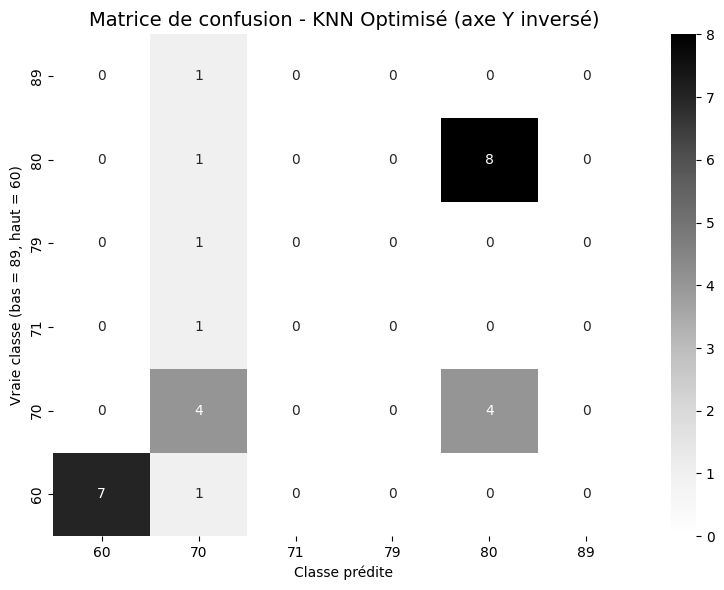

Modèle KNN optimisé enregistré sous knn_model_tuned.pkl


In [100]:
print("\n--- Exécution de GridSearchCV pour KNN ---")
knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
knn_grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres KNN : {knn_grid_search.best_params_}")
print(f"Meilleur score de validation croisée KNN : {knn_grid_search.best_score_:.2f}")

# Utilisation de la fonction d'évaluation définie précédemment
y_pred_knn_optimized = evaluate_model(knn_grid_search.best_estimator_, X_test, y_test, "KNN Optimisé",le)
plot_inverted_confusion_matrix(y_test, y_pred_knn_optimized,le, "KNN Optimisé", 'Greys')
# Sauvegarde du modèle optimisé
joblib.dump(knn_grid_search.best_estimator_, "knn_model_tuned.pkl")
print("Modèle KNN optimisé enregistré sous knn_model_tuned.pkl")

In [101]:
grids = {
    "Random Forest": rf_grid_search,
    "Régression Logistique": lr_grid_search,
    "Decision Tree": dt_grid_search,
    "SVM": svm_grid_search,
    "KNN": knn_grid_search
}

# Liste pour stocker les résultats
results = []

print("\n--- Comparaison des modèles optimisés par GridSearchCV ---")
for name, grid in grids.items():
    best_model = grid.best_estimator_ # Accéder au meilleur modèle entraîné par GridSearchCV
    y_pred = best_model.predict(X_test)
    
    results.append({
        "Modèle": name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 4),
        "Precision (macro)": round(precision_score(y_test, y_pred, average='macro', zero_division=0), 4),
        "Recall (macro)": round(recall_score(y_test, y_pred, average='macro', zero_division=0), 4),
        "F1-score (macro)": round(f1_score(y_test, y_pred, average='macro', zero_division=0), 4),
        "Meilleurs Paramètres": grid.best_params_ # Ajout des meilleurs paramètres pour la comparaison
    })

# Création du DataFrame des résultats
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="F1-score (macro)", ascending=False)

print(df_results.to_string()) # Utiliser to_string() pour afficher toutes les colonnes sans troncature
print("\n--- Comparaison terminée. ---")
import joblib

if 'df_results' in locals() and not df_results.empty and 'grids' in locals():
    best_model_name_str = df_results.iloc[0]['Modèle']
    
    if best_model_name_str in grids:
        best_grid_search_object = grids[best_model_name_str]
        best_overall_model = best_grid_search_object.best_estimator_
        
        save_filename = f"{best_model_name_str.replace(' ', '_').lower()}_best_model.pkl"
        
        joblib.dump(best_overall_model, save_filename)
        
        print(f"\n--- Le meilleur modèle '{best_model_name_str}' a été enregistré sous : {save_filename} ---")
    else:
        print(f"Erreur : Le modèle '{best_model_name_str}' trouvé dans df_results n'a pas été trouvé dans le dictionnaire 'grids'.")
        print("Veuillez vérifier que les clés du dictionnaire 'grids' correspondent exactement aux noms de modèles dans df_results.")
else:
    print("Le DataFrame 'df_results' ou le dictionnaire 'grids' n'est pas disponible ou est vide.")
    print("Veuillez d'abord exécuter le script de comparaison des modèles pour générer les résultats.")


--- Comparaison des modèles optimisés par GridSearchCV ---
                  Modèle  Accuracy  Precision (macro)  Recall (macro)  F1-score (macro)                                                Meilleurs Paramètres
0          Random Forest    0.8214             0.4249          0.4583            0.4364      {'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 50}
2          Decision Tree    0.8214             0.4249          0.4583            0.4364  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5}
1  Régression Logistique    0.7143             0.3767          0.3981            0.3754                     {'C': 10.0, 'max_iter': 200, 'solver': 'lbfgs'}
4                    KNN    0.6786             0.3519          0.3773            0.3610    {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
3                    SVM    0.6786             0.3406          0.3796            0.3569                   {'C': 10.0, 'gamma': 'scale', 'kernel': 'linear'}

---

Script

In [102]:
code = '''\
import numpy as np
import joblib

# Chargement des objets préentraînés
scaler = joblib.load("scaler.save")
label_encoder = joblib.load("label_encoder.save")
model = joblib.load("random_forest_best_model.pkl")  

def predire_navire(length, width, draft):
    specs = np.array([[length, width, draft]])
    specs_scaled = scaler.transform(specs)
    prediction_encoded = model.predict(specs_scaled)
    prediction_label = label_encoder.inverse_transform(prediction_encoded)
    return prediction_label[0]

if __name__ == "__main__":
    longueur = float(input(" Longueur (m) : "))
    largeur = float(input(" Largeur (m) : "))
    tirant_eau = float(input(" Tirant d'eau (m) : "))
    type_prédit = predire_navire(longueur, largeur, tirant_eau)
    print(f" Type de navire prédit : {type_prédit}")
'''

# Création du script
with open("prediction_navire.py", "w", encoding="utf-8") as f:
    f.write(code)

print("Script enregistré dans 'prediction_navire.py'")


Script enregistré dans 'prediction_navire.py'
